## Load Packages

In [22]:
import pandas as pd
import numpy as np
from scipy import stats
from pathlib import Path

# formatting
import re
def add_comma(match):
    return match.group(0) + ','

#Preprocessing
from scipy.stats import pearsonr, mode 
from numpy import nanmean, nanstd

# plots
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.patches import Patch

# #add folder to path for custom module imports
# import sys
# sys.path.append("scripts")

#custom functions
from functions import getResponses, chooseData, chooseEmb, getEmbeddings, getData, predModel, corrUserBased #general auxiliary function
from functions import compareModels, modelPerformance #model training and comparison
from functions import regCorr, mean_confidence_interval, pearsonr_ci, welch_t_test #human judges comparison

from functions import targetComparison, predictionPerformance

#random state
randState = 0

#warning messages
import warnings
warnings.filterwarnings("ignore", message="An input array is constant; the correlation coefficient is not defined.")

## Analyze Performance

### Calculate model performances (only run once/if not already saved)

16PF

In [ ]:
#calculate model performance (only needs to run once)
modelPerformance(m=4, par=5, d="16PF", e="sentencebert", verbose=1) #fit a single model with specified parameter, report performance
#m -> #0: Ridge regression, #1: RidgeClass, #2:KNN, #3: Kernel SVC (RBF), #4: KNN Regression

#baseline: Word2Vec
modelPerformance(m=3, par=10, d="16PF", e="word2vec", verbose=1) #fit a single model with specified parameter, report performance

#baseline: LIWC
modelPerformance(m=0, par=10, d="16PF", e="liwc", verbose=1) #fit a single model with specified parameter, report performance

RIASEC

In [ ]:
#calculate model performance (only needs to run once)
modelPerformance(m=4, par=5, d="RIASEC", e="sentencebert", verbose=1) #fit a single model with specified parameter, report performance
#m -> #0: Ridge regression, #1: RidgeClass, #2:KNN, #3: Kernel SVC (RBF), #4: KNN Regression

#baseline: Word2Vec
modelPerformance(m=3, par=10, d="RIASEC", e="word2vec", verbose=1) #fit a single model with specified parameter, report performance

#baseline: LIWC
modelPerformance(m=0, par=10, d="RIASEC", e="liwc", verbose=1) #fit a single model with specified parameter, report performance

HSQ

In [ ]:
#calculate model performance (only needs to run once)
modelPerformance(m=4, par=5, d="HSQ", e="sentencebert", verbose=1) #fit a single model with specified parameter, report performance
#m -> #0: Ridge regression, #1: RidgeClass, #2:KNN, #3: Kernel SVC (RBF), #4: KNN Regression

#baseline: Word2Vec
modelPerformance(m=3, par=10, d="HSQ", e="word2vec", verbose=1) #fit a single model with specified parameter, report performance

#baseline: LIWC
modelPerformance(m=0, par=10, d="HSQ", e="liwc", verbose=1) #fit a single model with specified parameter, report performance

### Load model performances (run instead of section above -- much faster)

In [5]:
datasets = ["16PF", "RIASEC", "HSQ"]

for d in datasets:
    #Choose Data Set:
    R = 2           #1: reversed-coded, #2: nonReversed-coded

    #best Model (KnnRegression k=5, no reverse-coding):
    m = 4          #0: Ridge, #1: RidgeClass, #2:KNN, #3: Kernel SVM (RBF), #4: KNN regression
    par = 5
    e = 'sentencebert'
    model, modelName = predModel(m,par)

    #load path and necessary variables:
    folder, data = chooseData(d)        
    embeddings, save = chooseEmb(e)     #LIWC, WORD2VEC, SENTENCEBERT
    responses, savePath, items, _ = getResponses(folder, data, R) #1: Reversed, #2: nonReversed
    responses = responses.astype(float) #get observed responses as floats
    X, X_stand, X_pca_stand = getEmbeddings(folder, data, embeddings, responses)

    #get embeddings name:
    embName = embeddings.split("_")[2].split(".")[0]

    # import required data and labels
    data_q, constructs_list, list_par, constrAssigned = getData(m, responses, X_pca_stand, folder, data)

    # get predicted responses of chosen model:
    total_preds = pd.read_csv(savePath + modelName + "_" + str(par) + "_" + embName + "_responses.csv", index_col=0)
    total_preds.index = total_preds.index.map(str)
    total_preds = total_preds.astype(float)

    #get model performance:
    corr, means = corrUserBased(total_preds, responses)
    print("Dataset: " + d.upper())
    print("Correlation, lower-CI, upper-CI, p-value, t-statistic, DOF")
    print(list(np.round(means, 3))) #corr, p, l1, ci lower, ci upper, t-stats, df
    print("\n")
    print("Percentage of significant positive correlations: ")
    print(round(np.mean((corr.Correlation>0) & (corr["p-value"]<0.05)), 3))

Dataset: 16PF
Correlation, lower-CI, upper-CI, p-value, t-statistic, DOF
[0.388, 0.0, 0.387, 0.389, 585.486, 49157.0]


Percentage of significant positive correlations: 
0.933
Dataset: RIASEC
Correlation, lower-CI, upper-CI, p-value, t-statistic, DOF
[0.349, 0.0, 0.348, 0.35, 594.911, 135762.0]


Percentage of significant positive correlations: 
0.647
Dataset: HSQ
Correlation, lower-CI, upper-CI, p-value, t-statistic, DOF
[0.34, 0.0, 0.32, 0.36, 33.205, 588.0]


Percentage of significant positive correlations: 
0.514


## Performance Plots (Model & Baselines)

### Calculate performance across data sets

Creates a dataframe with the performance in the response prediction task of each embedding type for all data sets of Study 2

In [11]:
# best performing model:
m   = 4               #0: Ridge, #1: RidgeClass, #2:KNN, #3: Kernel SVM (RBF)
par = 5
e   = 'sentencebert'

model, modelName = predModel(m,par) 

datasets = ['16PF', 'HSQ', 'RIASEC']
performance = pd.DataFrame(columns=["Dataset", "Model", "Correlation", "p-value", "L1 Loss"])
sig_data = []

#iterate through datasets
for i,nr in zip(datasets, range(len(datasets))):
  #add LIWC - Baseline
      #load prediction and baseline data
  folder, data = chooseData(i)
  responses, savePath, items, _ = getResponses(folder, data, 2)
  total_preds = pd.read_csv(savePath + modelName + "_" + str(par) + "_" + e.upper() + "_responses.csv", index_col=0)
  total_dumb = pd.read_csv(savePath + 'baseline_responses.csv', index_col=0) #naive baseline
  responses.index = total_preds.index
      #get performances
  results, resultsMean = corrUserBased(total_preds, responses)
  results_dumb, resultsMean_dumb = corrUserBased(total_dumb, responses)
  results.insert(0,'Model',['Best Model']*results.shape[0])
  results.insert(0,'Dataset',[i]*results.shape[0])
  results_dumb.insert(0,'Model',['Average Response']*results_dumb.shape[0])
  results_dumb.insert(0,'Dataset',[i]*results_dumb.shape[0])
  
  # get percentage of significant positive correlations
  sig_count = results.loc[(results.Correlation > 0) & (results["p-value"]<0.05),:].shape[0]/results.shape[0]
  sig_data.append([i, "SBERT", sig_count])

  #combine correlations of all datasets in one frame
  performance = pd.concat([performance, results], ignore_index = True)

  #add word2vec Baseline
  mName_w2v = "SVC"
  par_w2v = 10
  total_preds3 = pd.read_csv(savePath + mName_w2v + "_" + str(par_w2v) + "_" + "WORD2VEC".upper() + "_responses.csv", index_col=0)
  responses.index = total_preds3.index
      #get performances
  results3, resultsMean2 = corrUserBased(total_preds3, responses)
  results3.insert(0,'Model',['WORD2VEC']*results3.shape[0])
  results3.insert(0,'Dataset',[i]*results3.shape[0])

  # get percentage of significant positive correlations
  sig_count = results3.loc[(results3.Correlation > 0) & (results3["p-value"]<0.05),:].shape[0]/results3.shape[0]
  sig_data.append([i, "WORD2VEC", sig_count])

  #combine correlations of all datasets in one frame
  performance = pd.concat([performance, results3], ignore_index = True)

  #add LIWC -- Baseline
  mName_liwc = "Ridge"
  par_liwc = 10
  total_preds2 = pd.read_csv(savePath + mName_liwc + "_" + str(par_liwc) + "_" + "LIWC".upper() + "_responses.csv", index_col=0)
  responses.index = total_preds2.index
      #get performances
  results2, resultsMean2 = corrUserBased(total_preds2, responses)
  results2.insert(0,'Model',['LIWC']*results.shape[0])
  results2.insert(0,'Dataset',[i]*results.shape[0])
  
  # get percentage of significant positive correlations
  sig_count = results2.loc[(results2.Correlation > 0) & (results2["p-value"]<0.05),:].shape[0]/results2.shape[0]
  sig_data.append([i, "LIWC", sig_count])

  #combine correlations of all datasets in one frame
  performance = pd.concat([performance, results2], ignore_index = True)
  performance = pd.concat([performance, results_dumb], ignore_index = True)

# save results
performance.to_csv("../plot_data/performances_s2.csv")

### Plot from pre-saved data

<Figure size 3600x6480 with 0 Axes>

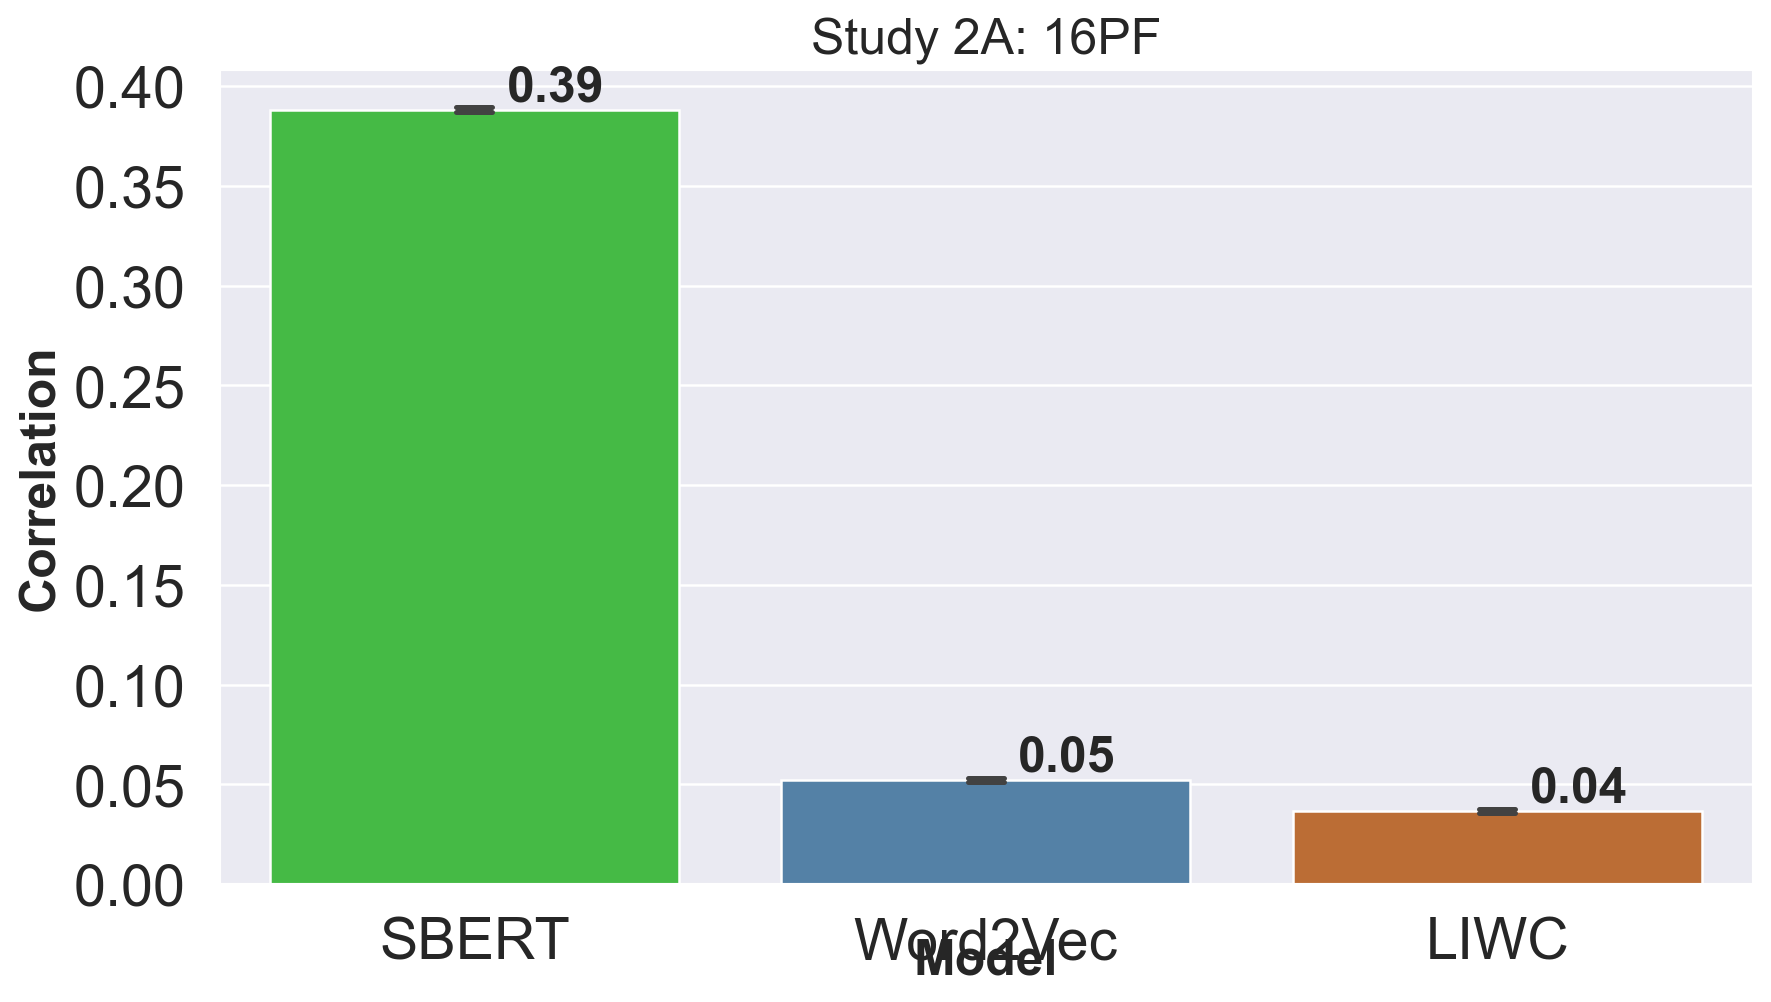

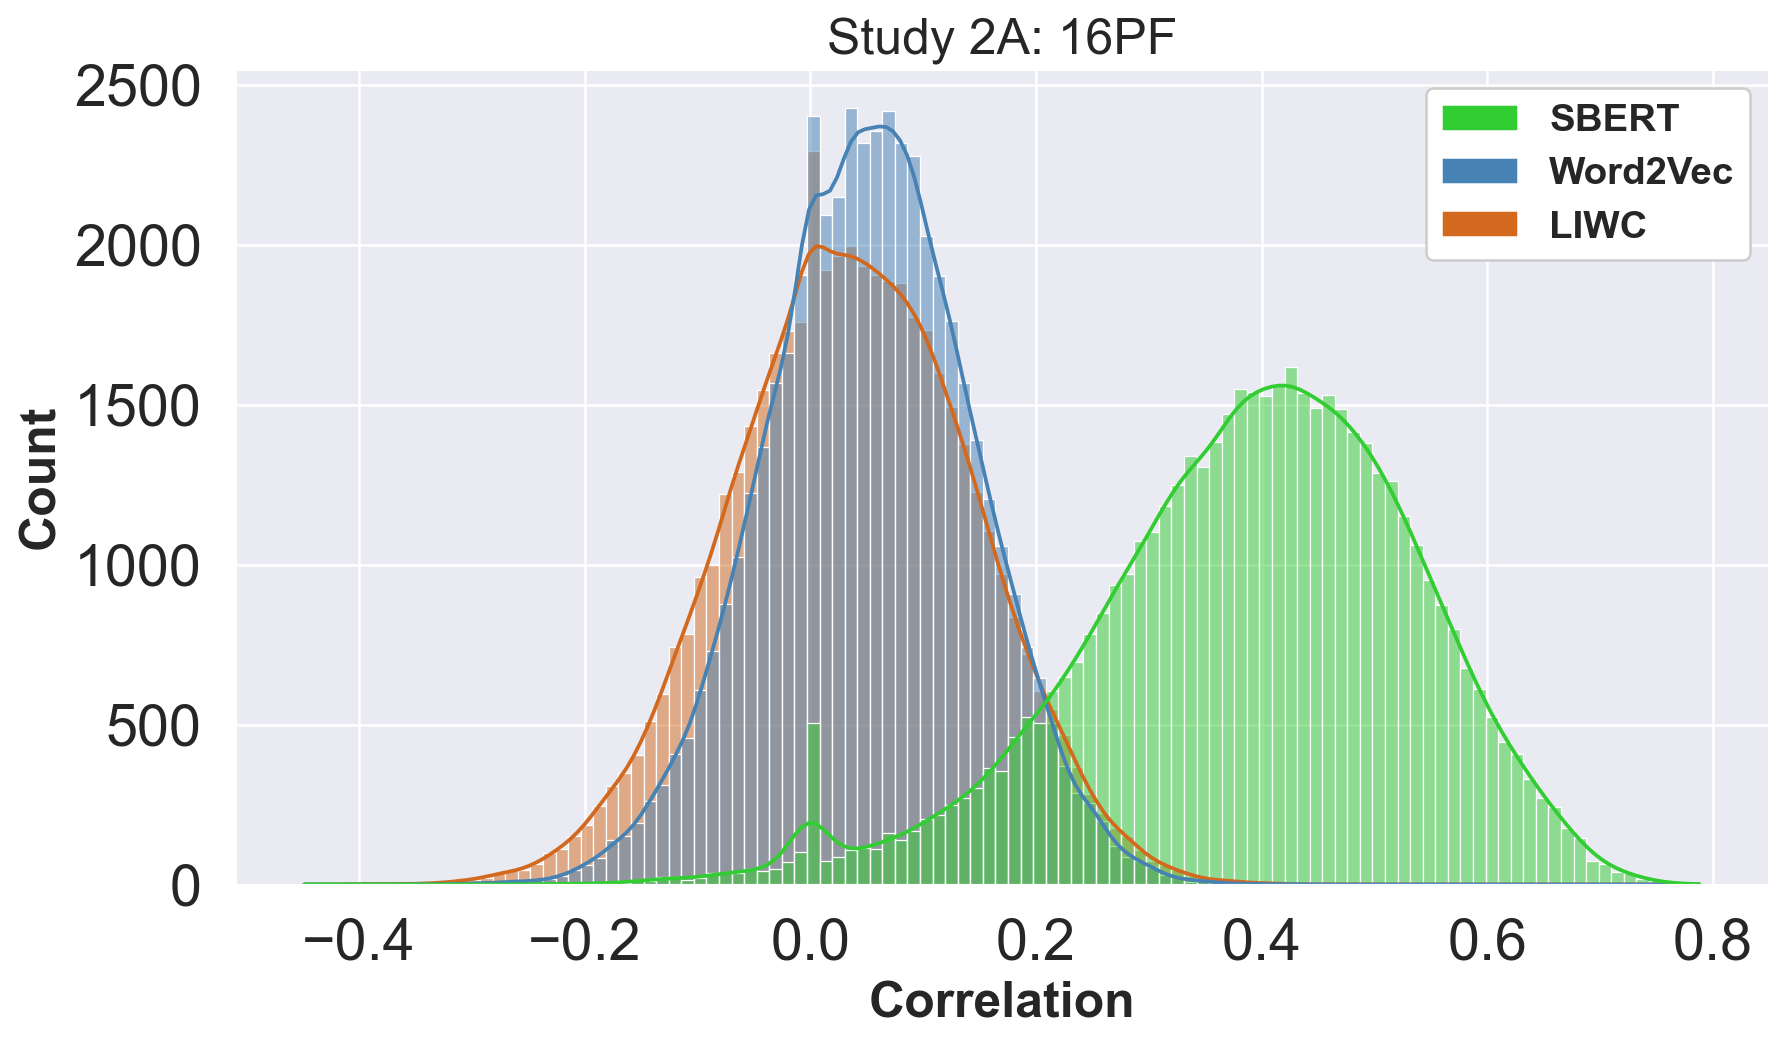

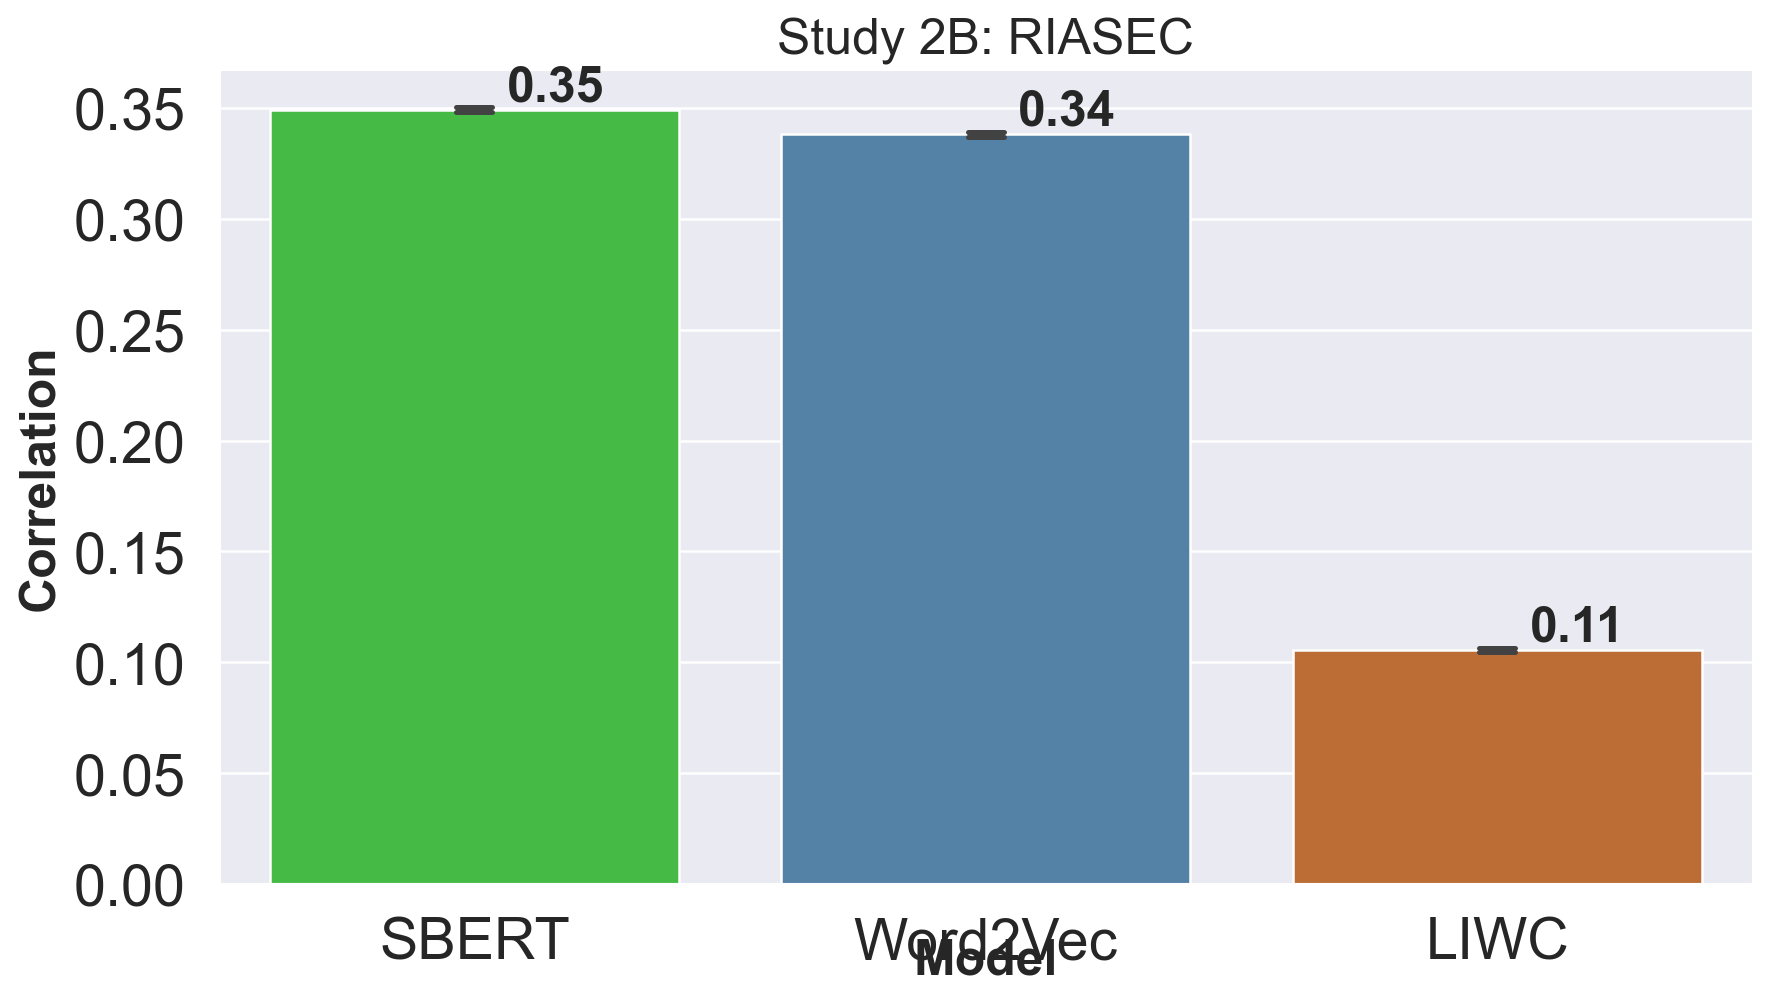

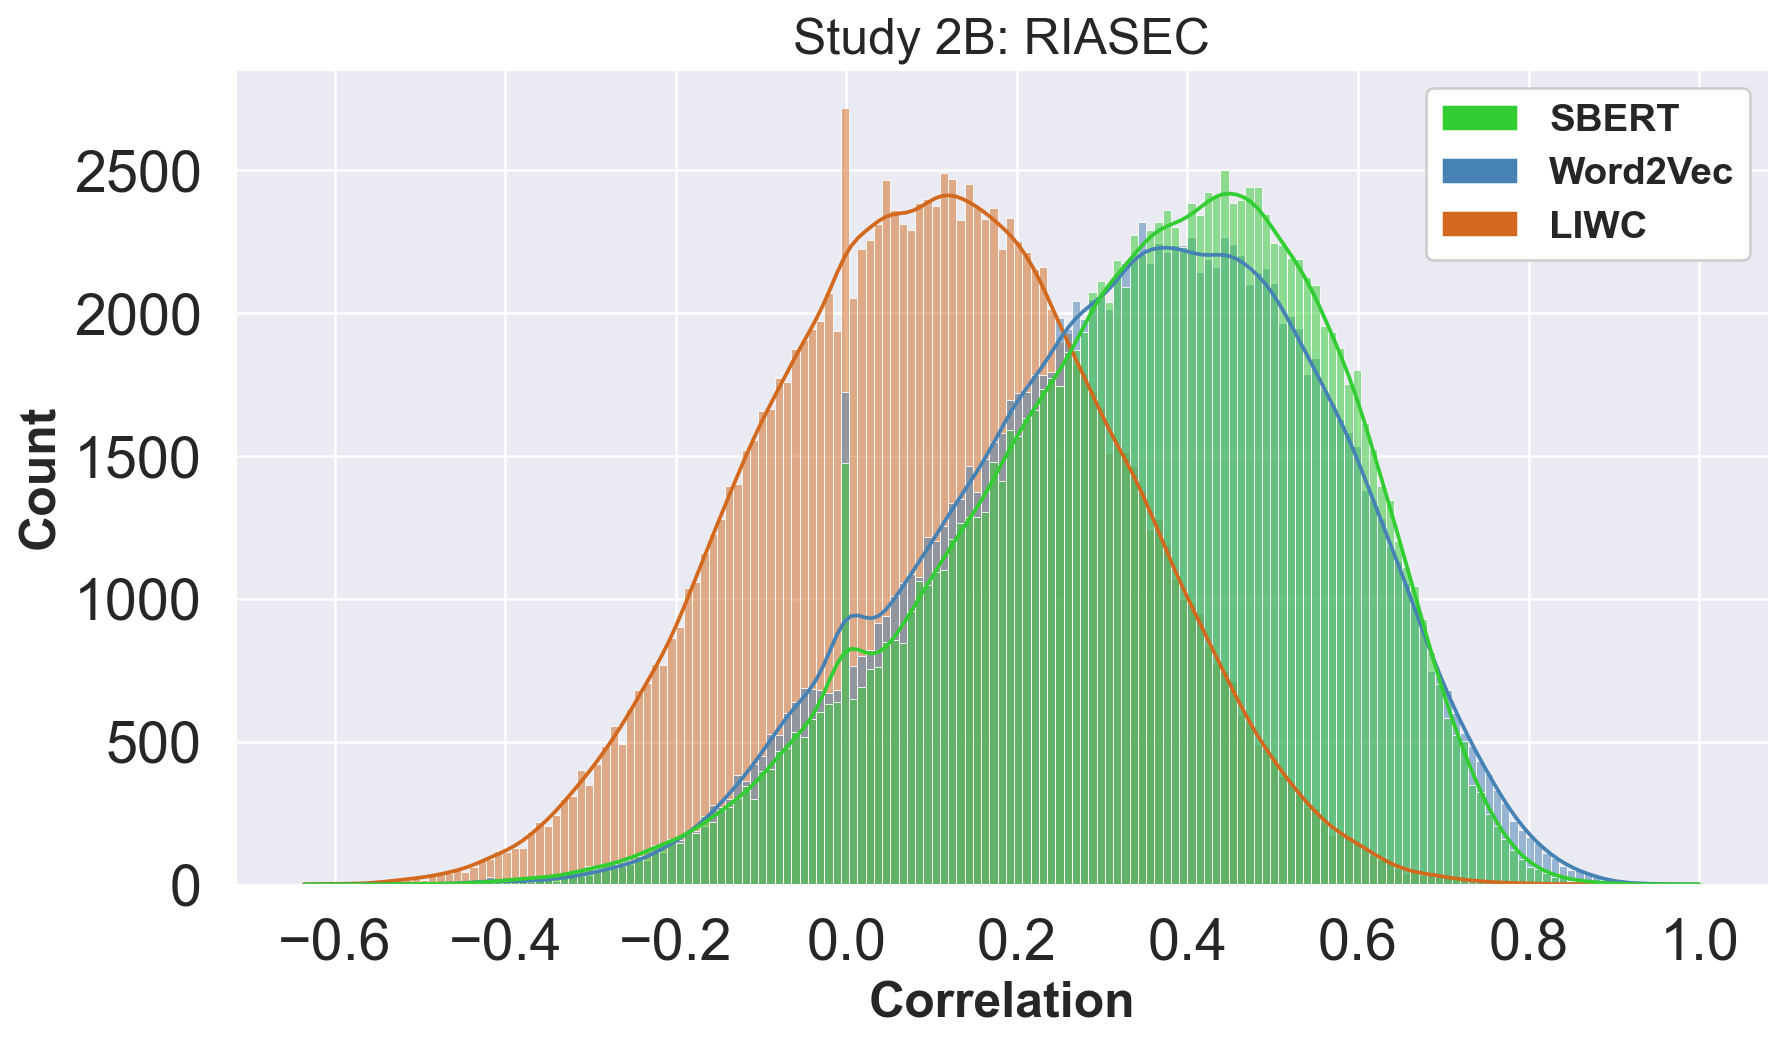

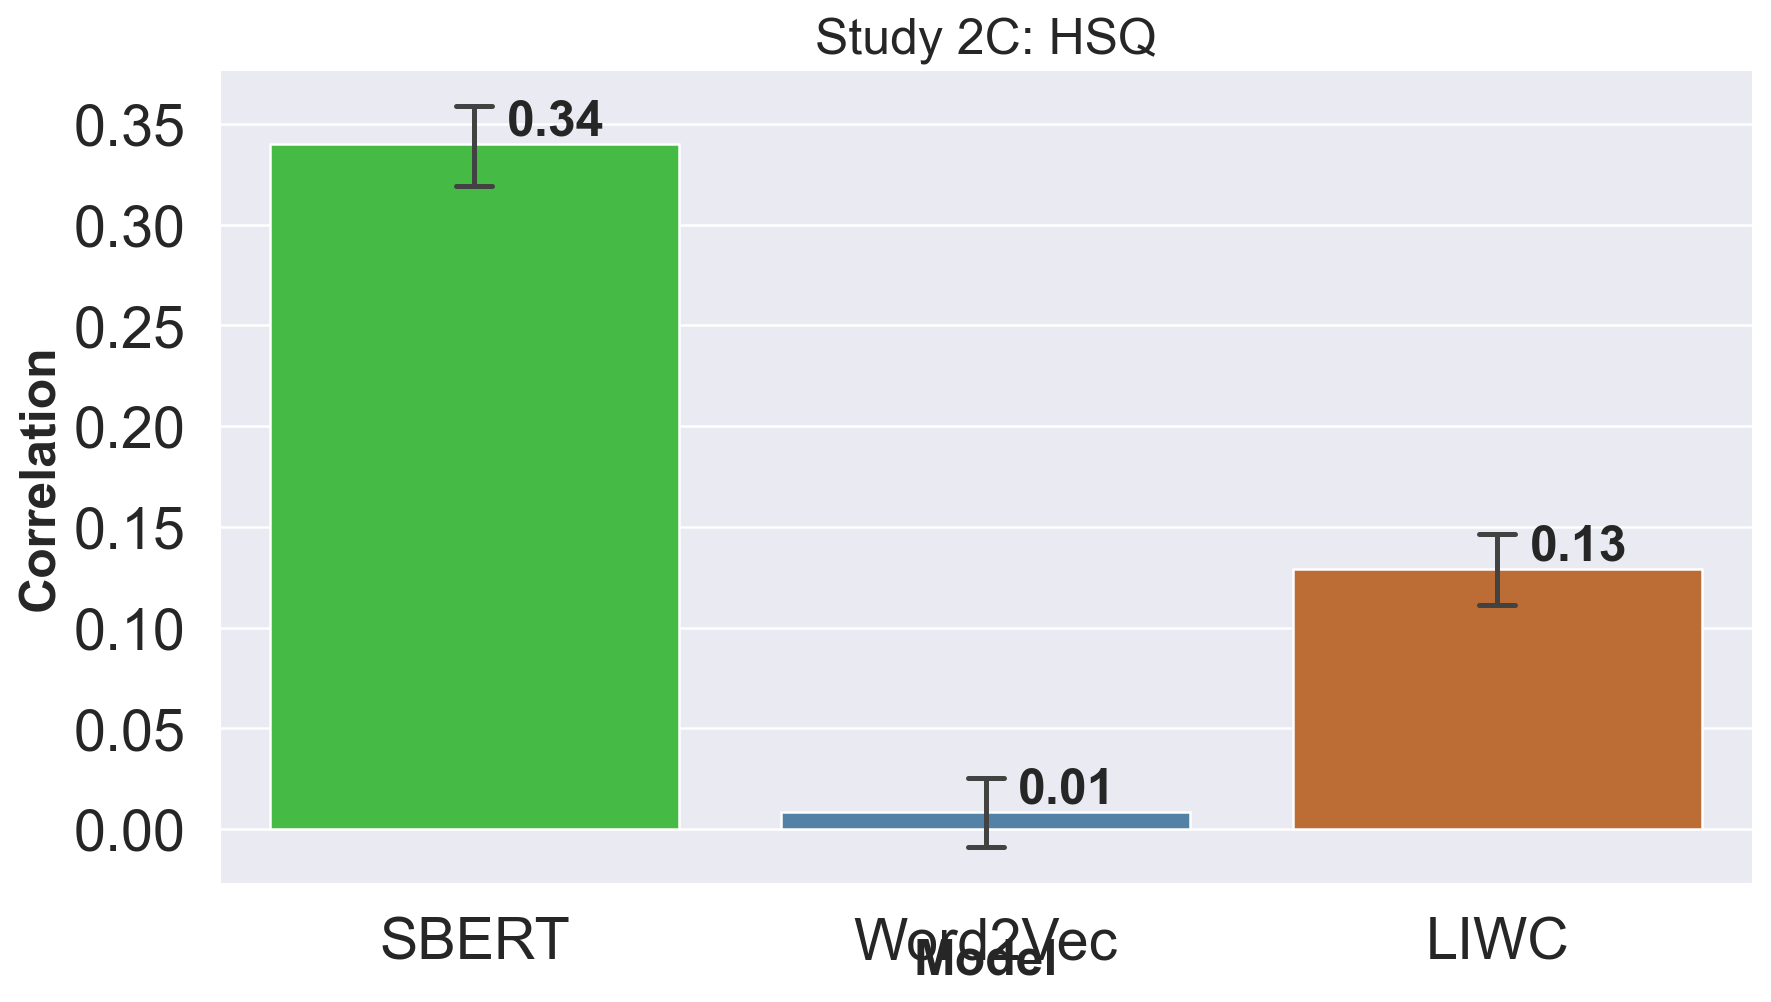

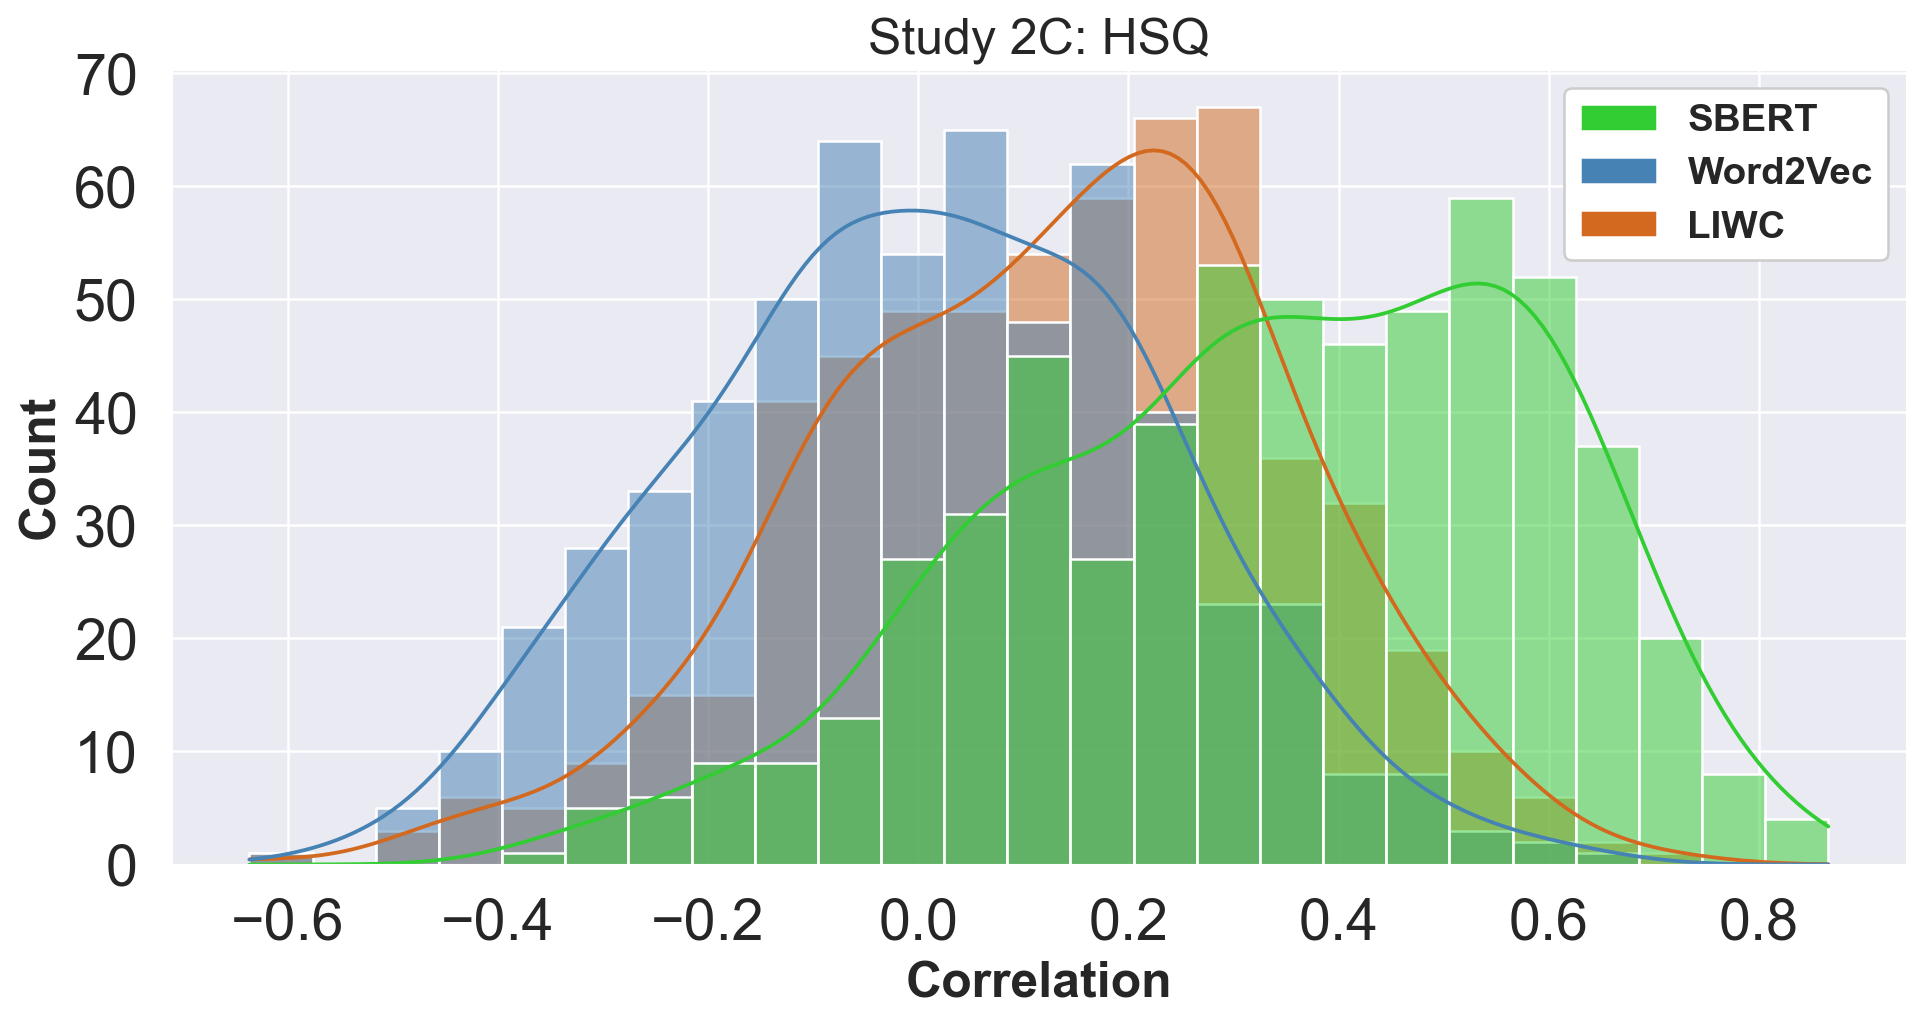

In [13]:
performance = pd.read_csv("../plot_data/performances_s2.csv", index_col=0)

# reshape data frame to show performance for each embedding type
cols = performance.columns.drop(['Dataset', 'Model'])
performance[cols] = performance[cols].astype(float)
performance = pd.melt(performance, id_vars=["Dataset", "Model"],var_name="predictor", value_name="metric value")
plot_data = performance[(performance['predictor'] == 'Correlation')].copy()
plot_data.loc[plot_data.Model == "Best Model", 'Model'] = "SBERT"

# rename for better display in plots
plot_data['Model'] = ["Word2Vec" if item=="WORD2VEC" else item for item in plot_data['Model']]
plot_data['Model'] = ["Average\nResponse" if item=="Average Response" else item for item in plot_data['Model']]

#create plots
fig  = plt.figure(figsize=(20, 36), dpi= 180)
sns.set(font_scale = 1)
order = ['16PF', 'RIASEC', "HSQ"]
dataset_names = ['Study 2A: 16PF', 'Study 2B: RIASEC', "Study 2C: HSQ"]

#Plot style and meta
plt.style.use("seaborn-v0_8")
sns.set_context('paper')
sns.set(font_scale = 1.4)
for i in range(1,4):

    #Add the performance plots:
    data = plot_data[(plot_data.Dataset == order[i-1]) & (plot_data.Model != "Average\nResponse")]
    fig  = plt.figure(figsize=(11, 6), dpi= 180)
    ax = sns.barplot(y='metric value', x='Model', orient='v', data=data, errorbar=('ci', 95), palette=["limegreen","steelblue", "chocolate", "sandybrown"], capsize=0.07, errwidth=2)
    for p in ax.patches:
      if p.get_height() < 0:
        height = -6
      else:
        height = 6
      ax.annotate("%.2f" % round(p.get_height(),2), xy=(p.get_x() + p.get_width() / 2, p.get_height()),
              xytext=(13, height + 3), textcoords='offset points', ha="left", va="center", fontweight='bold',fontsize=20)
    plt.ylabel("Correlation", fontweight='bold', fontsize=20)
    plt.xlabel("Model", fontweight='bold', fontsize=20, labelpad=-13)
    plt.title(dataset_names[i-1], fontsize=20)
    plt.xticks(fontsize=23)
    plt.yticks(fontsize=23)

    fig_name = "fig2_" + chr(65+2*i) + ".pdf"
    plt.savefig("../plot_data/" + fig_name, bbox_inches='tight')

    #Add the distribution plots for each data set:
    fig  = plt.figure(figsize=(11, 6), dpi= 180)
    palette=["limegreen","steelblue", "chocolate"]
    ax = sns.histplot(data, x="metric value", kde=True, hue="Model", palette = palette)
    from matplotlib.patches import Patch
    handles = [Patch(facecolor=item) for item in palette]
    labels = data.Model.unique().tolist()
    ax.legend(handles = handles, labels = labels, frameon = True, framealpha = 1.0, facecolor='white', prop={'weight':'bold'})

    plt.ylabel("Count", fontweight='bold', fontsize=20)
    plt.xlabel("Correlation", fontweight='bold', fontsize=20)
    plt.title(dataset_names[i-1], fontsize=20)
    plt.xticks(fontsize=23)
    plt.yticks(fontsize=23)

    fig_name = "fig2_" + chr(65+2*i+1) + ".pdf"
    plt.savefig("../plot_data/" + fig_name, bbox_inches='tight')

plt.tight_layout()
plt.subplots_adjust(hspace = 1)
plt.show()

## Human Comparison

### Calculate and print performance overview

16PF

In [23]:
# lists to save the results across datasets (for plotting)
df_comparisons = []
targets_comparisons = []

#Choose Data Set:
R = 2           #1: reversed-coded, #2: nonReversed-coded
d = "16pf"      #BIG5. 16PF, RIASEC, HSQ, IPIP, IPIP2 (assigned items only)
h_path = "../human_studies/" + d.upper() + "/" + d.lower()

#best Model (KnnRegression k=5, no reverse-coding):
m = 4          #0: Ridge, #1: RidgeClass, #2:KNN, #3: Kernel SVM (RBF), #4: KNN regression
par = 5
e = 'sentencebert'
model, modelName = predModel(m,par)

#load path and necessary variables:
folder, data = chooseData(d)        
embeddings, save = chooseEmb(e)     #LIWC, WORD2VEC, SENTENCEBERT
savePath = "../results/"+folder+"nonReversed/"

#get embeddings name:
embName = embeddings.split("_")[2].split(".")[0]

# get predicted responses of chosen model:
total_preds = pd.read_csv(savePath + modelName + "_" + str(par) + "_" + embName + "_responses.csv", index_col=0)
total_preds.index = total_preds.index.map(str)
total_preds = total_preds.astype(float)

# load target responses (original data)
targets_data = pd.read_csv(h_path + "_targets_data.csv", index_col=0)
targets_data.index = targets_data.index.map(str)

# rename questions by order (e.g., "q1")
new_cols_names = ["q" + str(x) for x in range(1, len(targets_data.columns[4:])+1)] 
rename_cols_dict = {k:v for k,v in zip(targets_data.columns[4:].tolist(), new_cols_names)}
targets_data.rename(columns=rename_cols_dict, inplace=True)  

# load human rater data (revised human study)
human_data = pd.read_csv(h_path + "_qualtrics_cleaned.csv", index_col = 0)
# load model predictions (original prediction model)
model_data = total_preds.loc[targets_data.index]
model_data = pd.merge(model_data, targets_data.target_nr, left_index=True, right_index=True) # add target_nr

# rename questions by order (e.g., "q1")
model_data.rename(columns=rename_cols_dict, inplace=True)  

df_folds = pd.read_csv(h_path + "_question_folds.csv") # save to files
df_folds.test_items = df_folds.test_items.apply(lambda x: re.sub(r'\[[0-9\.\s]+\]', add_comma, x)).apply(lambda x: re.sub(r'([0-9\.]+)', add_comma, x)).apply(lambda x: np.array(eval(x)[0]))
df_folds.train_items = df_folds.train_items.apply(lambda x: re.sub(r'\[[0-9\.\s]+\]', add_comma, x)).apply(lambda x: re.sub(r'([0-9\.]+)', add_comma, x)).apply(lambda x: np.array(eval(x)[0]))

targets_h, targets_m = targetComparison(targets_data, human_data, model_data, df_folds)
df_comparison = predictionPerformance(targets_data, human_data, model_data, df_folds)

df_comparisons.append(df_comparison)
targets_comparisons.append([targets_h, targets_m])

RIASEC

Load all necessary data (true target responses, model predictions, human judges ratings, etc.)

In [24]:
#Choose Data Set:
R = 2           #1: reversed-coded, #2: nonReversed-coded
d = "riasec"      #BIG5. 16PF, RIASEC, HSQ, IPIP, IPIP2 (assigned items only)
h_path = "../human_studies/" + d.upper() + "/" + d.lower()

#best Model (KnnRegression k=5, no reverse-coding):
m = 4          #0: Ridge, #1: RidgeClass, #2:KNN, #3: Kernel SVM (RBF), #4: KNN regression
par = 5
e = 'sentencebert'
model, modelName = predModel(m,par)

#load path and necessary variables:
folder, data = chooseData(d)        
embeddings, save = chooseEmb(e)     #LIWC, WORD2VEC, SENTENCEBERT
savePath = "../results/"+folder+"nonReversed/"

#get embeddings name:
embName = embeddings.split("_")[2].split(".")[0]

# get predicted responses of chosen model:
total_preds = pd.read_csv(savePath + modelName + "_" + str(par) + "_" + embName + "_responses.csv", index_col=0)
total_preds.index = total_preds.index.map(str)
total_preds = total_preds.astype(float)

# load target responses (original data)
targets_data = pd.read_csv(h_path + "_targets_data.csv", index_col=0)
targets_data.index = targets_data.index.map(str)

# rename questions by order (e.g., "q1")
new_cols_names = ["q" + str(x) for x in range(1, len(targets_data.columns[4:])+1)] 
rename_cols_dict = {k:v for k,v in zip(targets_data.columns[4:].tolist(), new_cols_names)}
targets_data.rename(columns=rename_cols_dict, inplace=True)  

# load human rater data (revised human study)
human_data = pd.read_csv(h_path + "_qualtrics_cleaned.csv", index_col = 0)
# load model predictions (original prediction model)
model_data = total_preds.loc[targets_data.index]
model_data = pd.merge(model_data, targets_data.target_nr, left_index=True, right_index=True) # add target_nr

# rename questions by order (e.g., "q1")
model_data.rename(columns=rename_cols_dict, inplace=True)  

df_folds = pd.read_csv(h_path + "_question_folds.csv") # save to files
df_folds.test_items = df_folds.test_items.apply(lambda x: re.sub(r'\[[0-9\.\s]+\]', add_comma, x)).apply(lambda x: re.sub(r'([0-9\.]+)', add_comma, x)).apply(lambda x: np.array(eval(x)[0]))
df_folds.train_items = df_folds.train_items.apply(lambda x: re.sub(r'\[[0-9\.\s]+\]', add_comma, x)).apply(lambda x: re.sub(r'([0-9\.]+)', add_comma, x)).apply(lambda x: np.array(eval(x)[0]))

targets_h, targets_m = targetComparison(targets_data, human_data, model_data, df_folds)
df_comparison = predictionPerformance(targets_data, human_data, model_data, df_folds)

df_comparisons.append(df_comparison)
targets_comparisons.append([targets_h, targets_m])

HSQ

In [25]:
#Choose Data Set:
R = 2           #1: reversed-coded, #2: nonReversed-coded
d = "hsq"      #BIG5. 16PF, RIASEC, HSQ, IPIP, IPIP2 (assigned items only)
h_path = "../human_studies/" + d.upper() + "/" + d.lower()

#best Model (KnnRegression k=5, no reverse-coding):
m = 4          #0: Ridge, #1: RidgeClass, #2:KNN, #3: Kernel SVM (RBF), #4: KNN regression
par = 5
e = 'sentencebert'
model, modelName = predModel(m,par)

#load path and necessary variables:
folder, data = chooseData(d)        
embeddings, save = chooseEmb(e)     #LIWC, WORD2VEC, SENTENCEBERT
savePath = "../results/"+folder+"nonReversed/"

#get embeddings name:
embName = embeddings.split("_")[2].split(".")[0]

# get predicted responses of chosen model:
total_preds = pd.read_csv(savePath + modelName + "_" + str(par) + "_" + embName + "_responses.csv", index_col=0)
total_preds.index = total_preds.index.map(str)
total_preds = total_preds.astype(float)

# load target responses (original data)
targets_data = pd.read_csv(h_path + "_targets_data.csv", index_col=0)
targets_data.index = targets_data.index.map(str)

# rename questions by order (e.g., "q1")
new_cols_names = ["q" + str(x) for x in range(1, len(targets_data.columns[4:])+1)] 
rename_cols_dict = {k:v for k,v in zip(targets_data.columns[4:].tolist(), new_cols_names)}
targets_data.rename(columns=rename_cols_dict, inplace=True)  

# load human rater data (revised human study)
human_data = pd.read_csv(h_path + "_qualtrics_cleaned.csv", index_col = 0)
# load model predictions (original prediction model)
model_data = total_preds.loc[targets_data.index]
model_data = pd.merge(model_data, targets_data.target_nr, left_index=True, right_index=True) # add target_nr

# rename questions by order (e.g., "q1")
model_data.rename(columns=rename_cols_dict, inplace=True)  

df_folds = pd.read_csv(h_path + "_question_folds.csv") # save to files
df_folds.test_items = df_folds.test_items.apply(lambda x: re.sub(r'\[[0-9\.\s]+\]', add_comma, x)).apply(lambda x: re.sub(r'([0-9\.]+)', add_comma, x)).apply(lambda x: np.array(eval(x)[0]))
df_folds.train_items = df_folds.train_items.apply(lambda x: re.sub(r'\[[0-9\.\s]+\]', add_comma, x)).apply(lambda x: re.sub(r'([0-9\.]+)', add_comma, x)).apply(lambda x: np.array(eval(x)[0]))

targets_h, targets_m = targetComparison(targets_data, human_data, model_data, df_folds)
df_comparison = predictionPerformance(targets_data, human_data, model_data, df_folds)

df_comparisons.append(df_comparison)
targets_comparisons.append([targets_h, targets_m])

Get average performance and test for significance (against zero)

In [26]:
datasets = ["16PF", "RIASEC", "HSQ"]
for i, (targets_h, targets_m) in enumerate(targets_comparisons): #check order
    print("Dataset: " + datasets[i])
    #humans
    h = [x for s in targets_h for x in s]
    ttest_h = stats.ttest_1samp(h, 0, nan_policy="omit")
    t_h = round(ttest_h[0], 3)
    p_h = round(ttest_h[1], 4)

    #model
    m = [x for s in targets_m for x in s]
    ttest_m = stats.ttest_1samp(m, 0, nan_policy="omit")
    t_m = round(ttest_m[0], 3)
    p_m = round(ttest_m[1], 4)
    
    model  = df_comparisons[i][df_comparison.Predictor == "Model"].dropna()
    # model = model[model.Correlation > -0.99] # remove extreme outlier
    humans = df_comparisons[i][df_comparison.Predictor == "Human"].dropna()

    # two-sample independent welch test 
    welch_stat = welch_t_test(np.mean(humans.Correlation), np.std(humans.Correlation, ddof=1), humans.Correlation.size,
                               np.mean(model.Correlation), np.std(model.Correlation, ddof=1), model.Correlation.size)

    
    print("Human raters performance across all targets:")
    print("Correlation, t-statistic, p-value, DOF")
    print([round(nanmean(h),3), t_h, p_h, len(h)-2])

    print("\nModel performance across all targets:")
    print("Correlation, t-statistic, p-value, DOF")
    print([round(nanmean(m),3), t_m, p_m, len(m)-2])
    
    print("\n Welch's t-test: Are model and human performance different?")
    print("t-statistic, p-value, DOF")
    print(welch_stat) #not significantly different! absolute difference very small
    
    # percentage of positive significant correlations: -> very similar and very positive
    pos_cor_h = round(np.mean(df_comparisons[i].Correlation[df_comparisons[i].Predictor == "Human"]>0), 3)*100 # 89% positive
    pos_cor_m = round(np.mean(df_comparisons[i].Correlation[df_comparisons[i].Predictor == "Model"]>0), 3)*100 # 91% positive 
    print("\nModel: " + str(pos_cor_m) + "% significant positive correlations.")
    print("Humans: " + str(pos_cor_h) + "% significant positive correlations.\n")

Dataset: 16PF
Human raters performance across all targets:
Correlation, t-statistic, p-value, DOF
[0.394, 33.59, 0.0, 598]

Model performance across all targets:
Correlation, t-statistic, p-value, DOF
[0.395, 37.016, 0.0, 598]

 Welch's t-test: Are model and human performance different?
t-statistic, p-value, DOF
(-0.0767008271856631, 0.9388748579683519, 1152.5936669034272)

Model: 88.2% significant positive correlations.
Humans: 87.5% significant positive correlations.

Dataset: RIASEC
Human raters performance across all targets:
Correlation, t-statistic, p-value, DOF
[0.322, 14.72, 0.0, 598]

Model performance across all targets:
Correlation, t-statistic, p-value, DOF
[0.381, 18.293, 0.0, 598]

 Welch's t-test: Are model and human performance different?
t-statistic, p-value, DOF
(-1.9517033542990538, 0.05123644792132462, 1060.197945392587)

Model: 66.8% significant positive correlations.
Humans: 64.2% significant positive correlations.

Dataset: HSQ
Human raters performance across all

## Plots

### Create scatterplot (model vs humans)

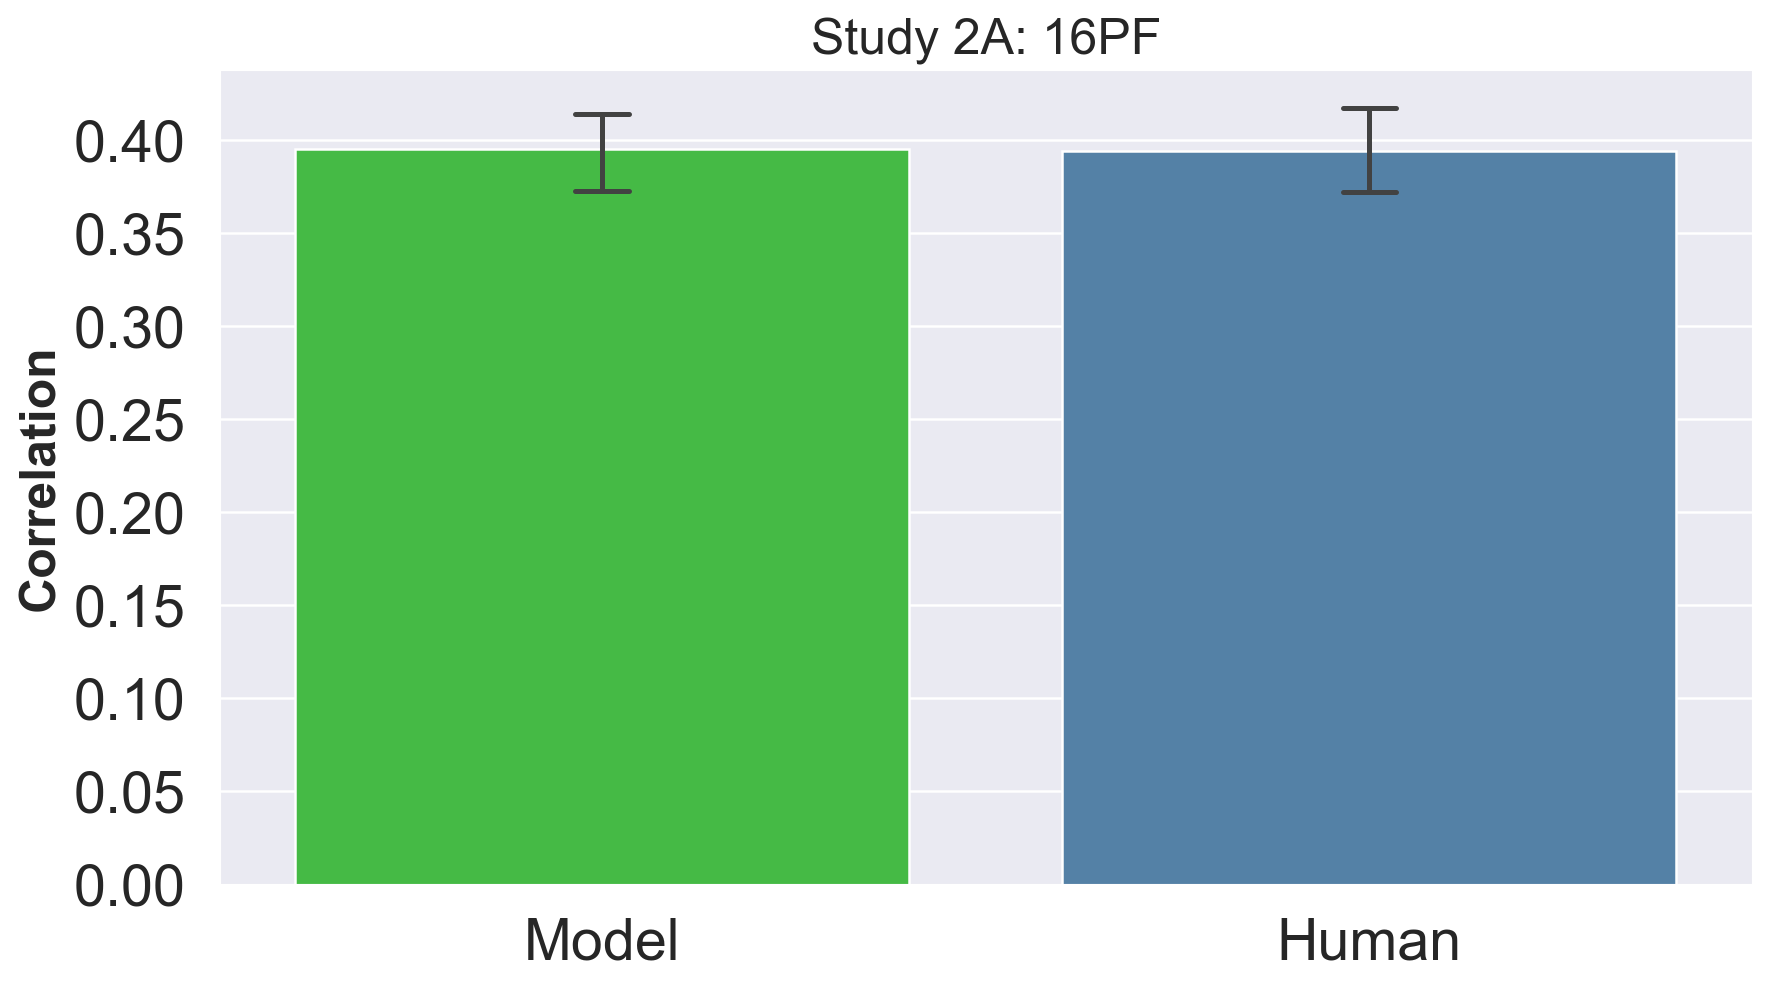

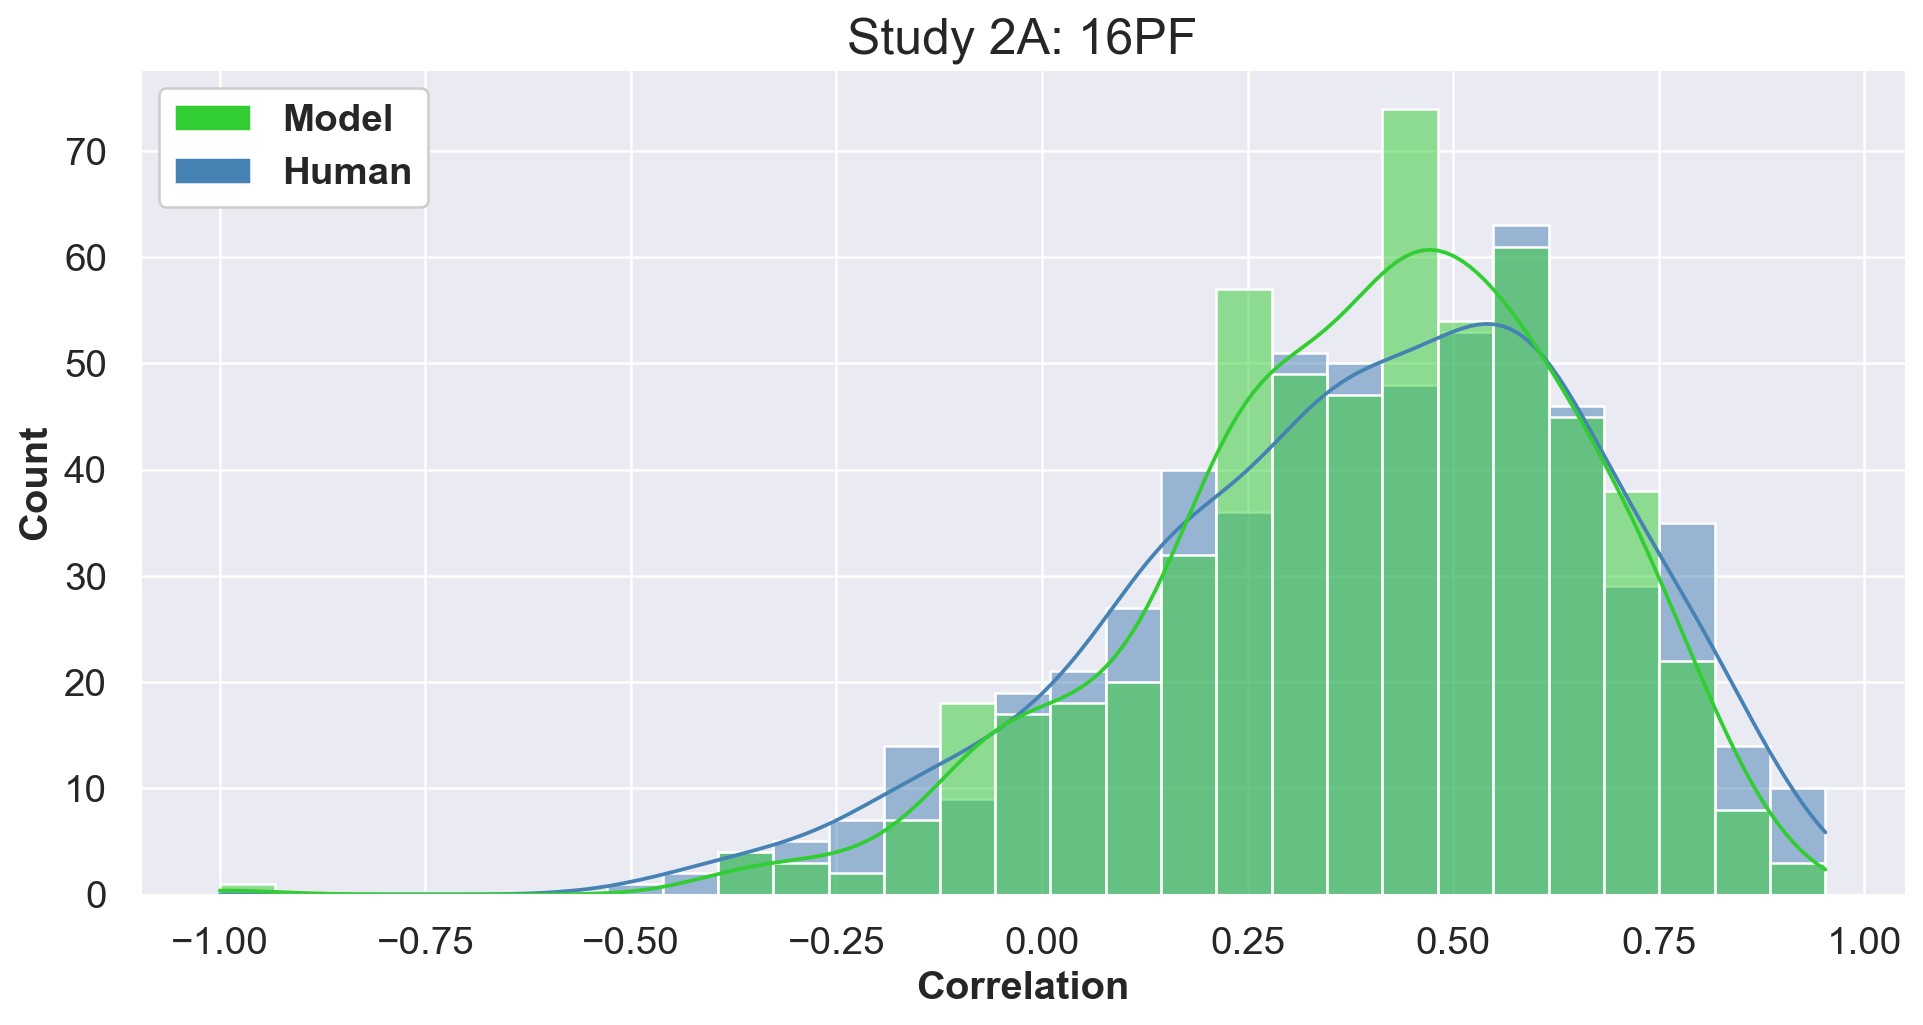

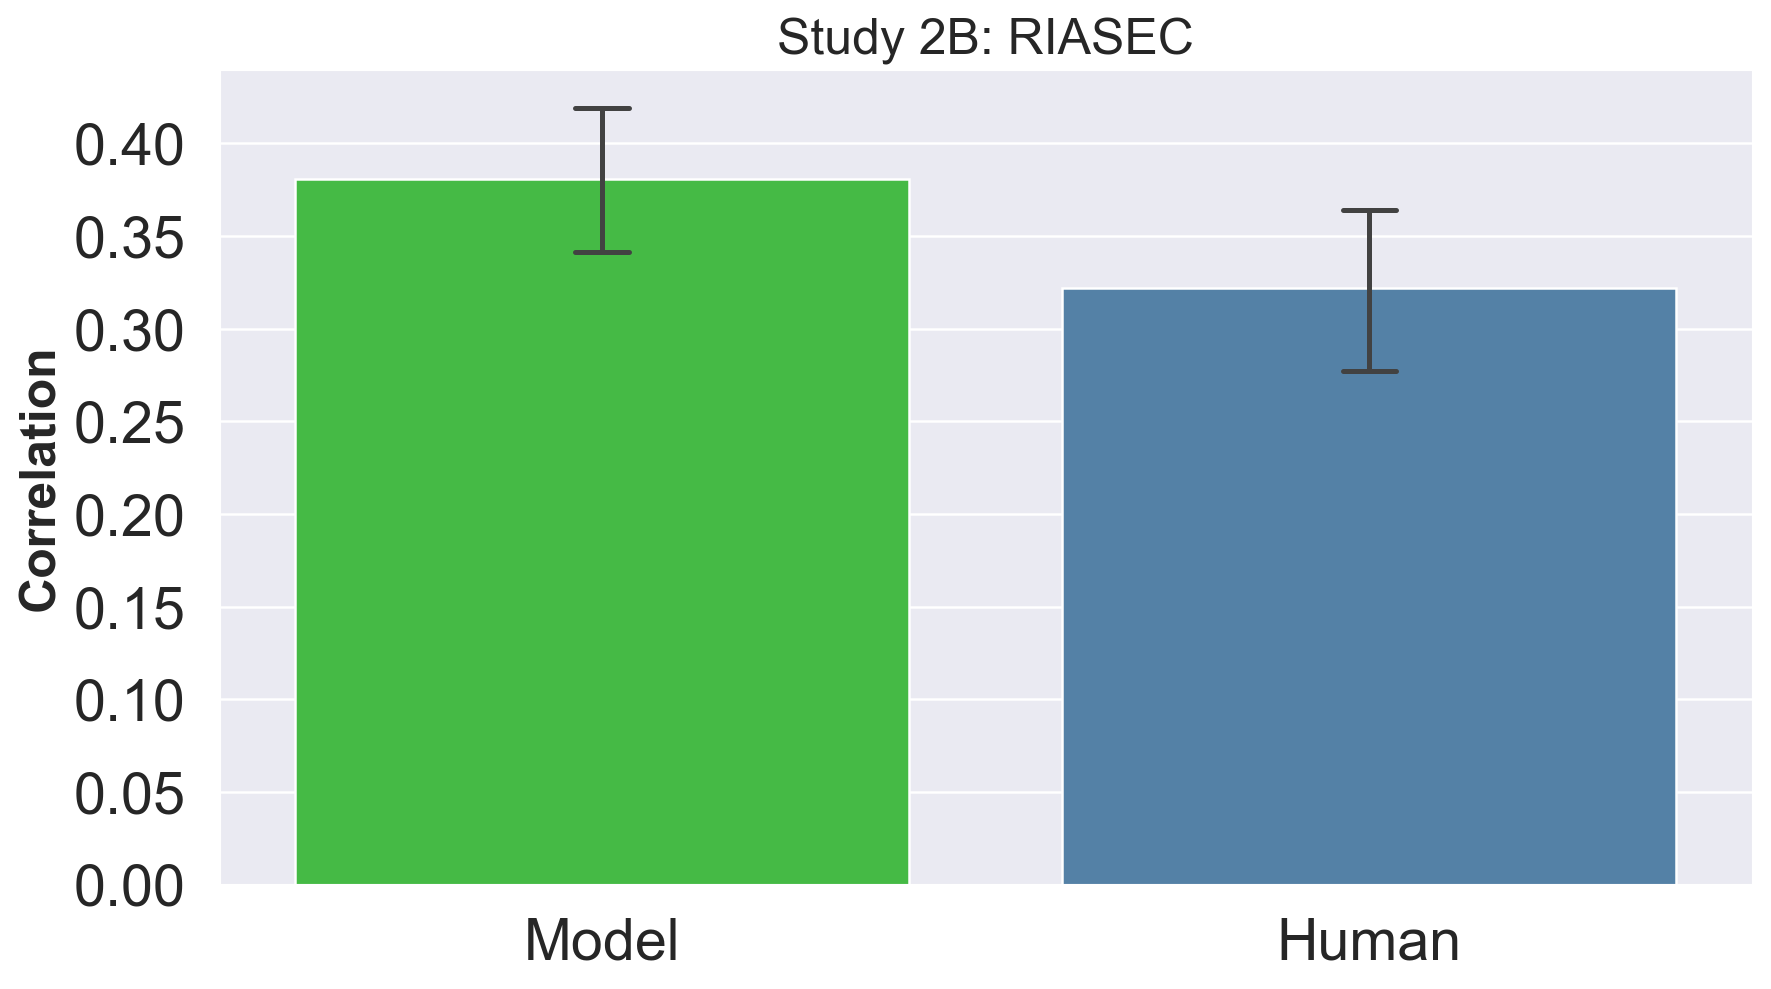

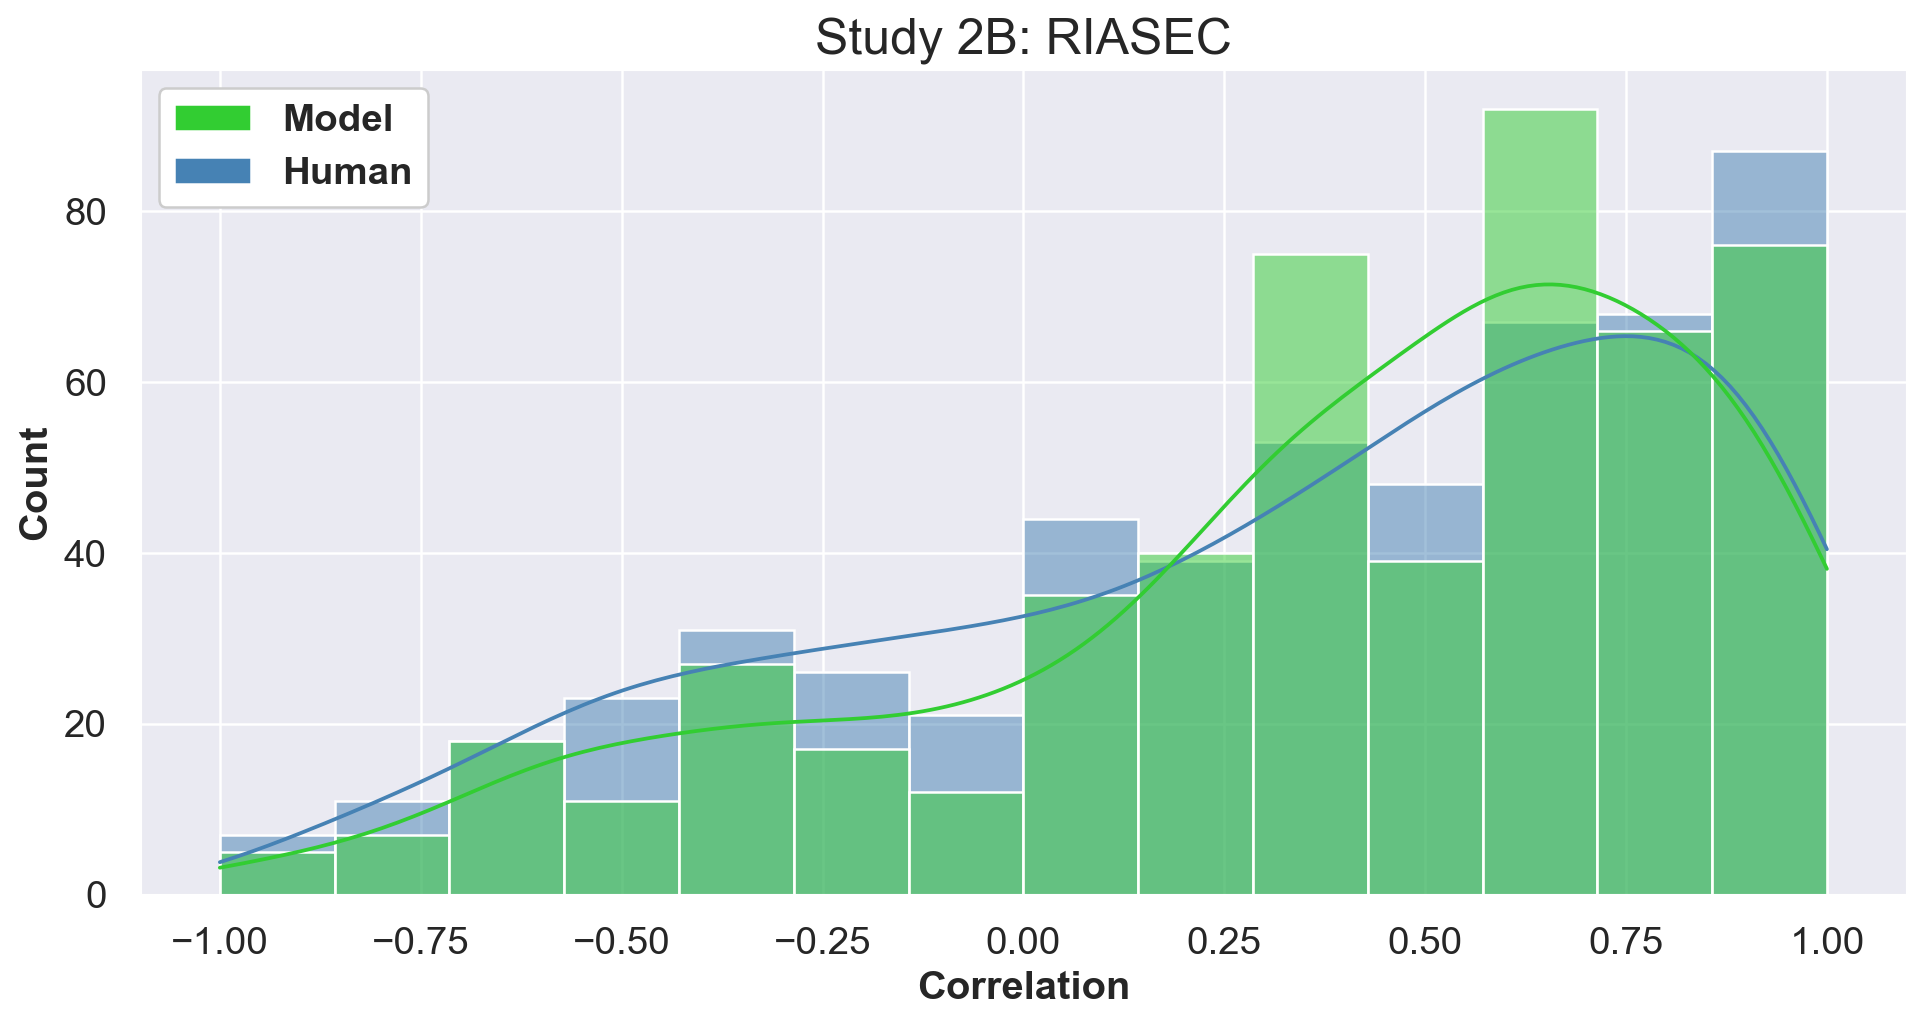

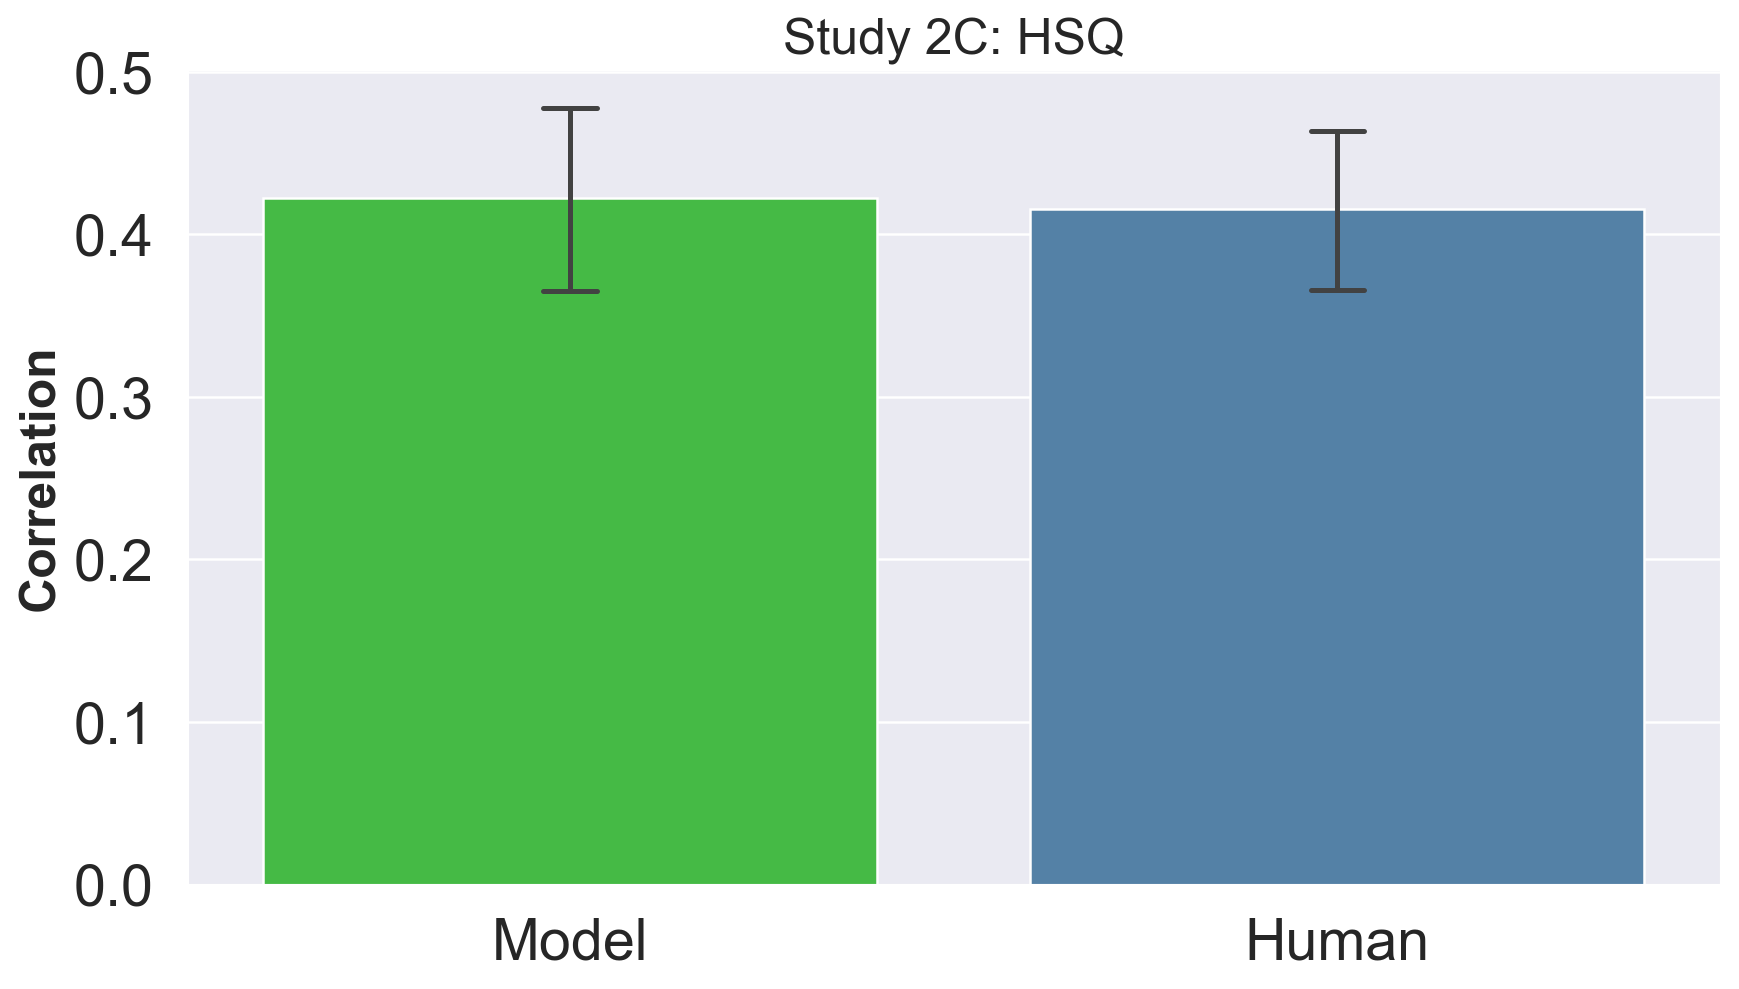

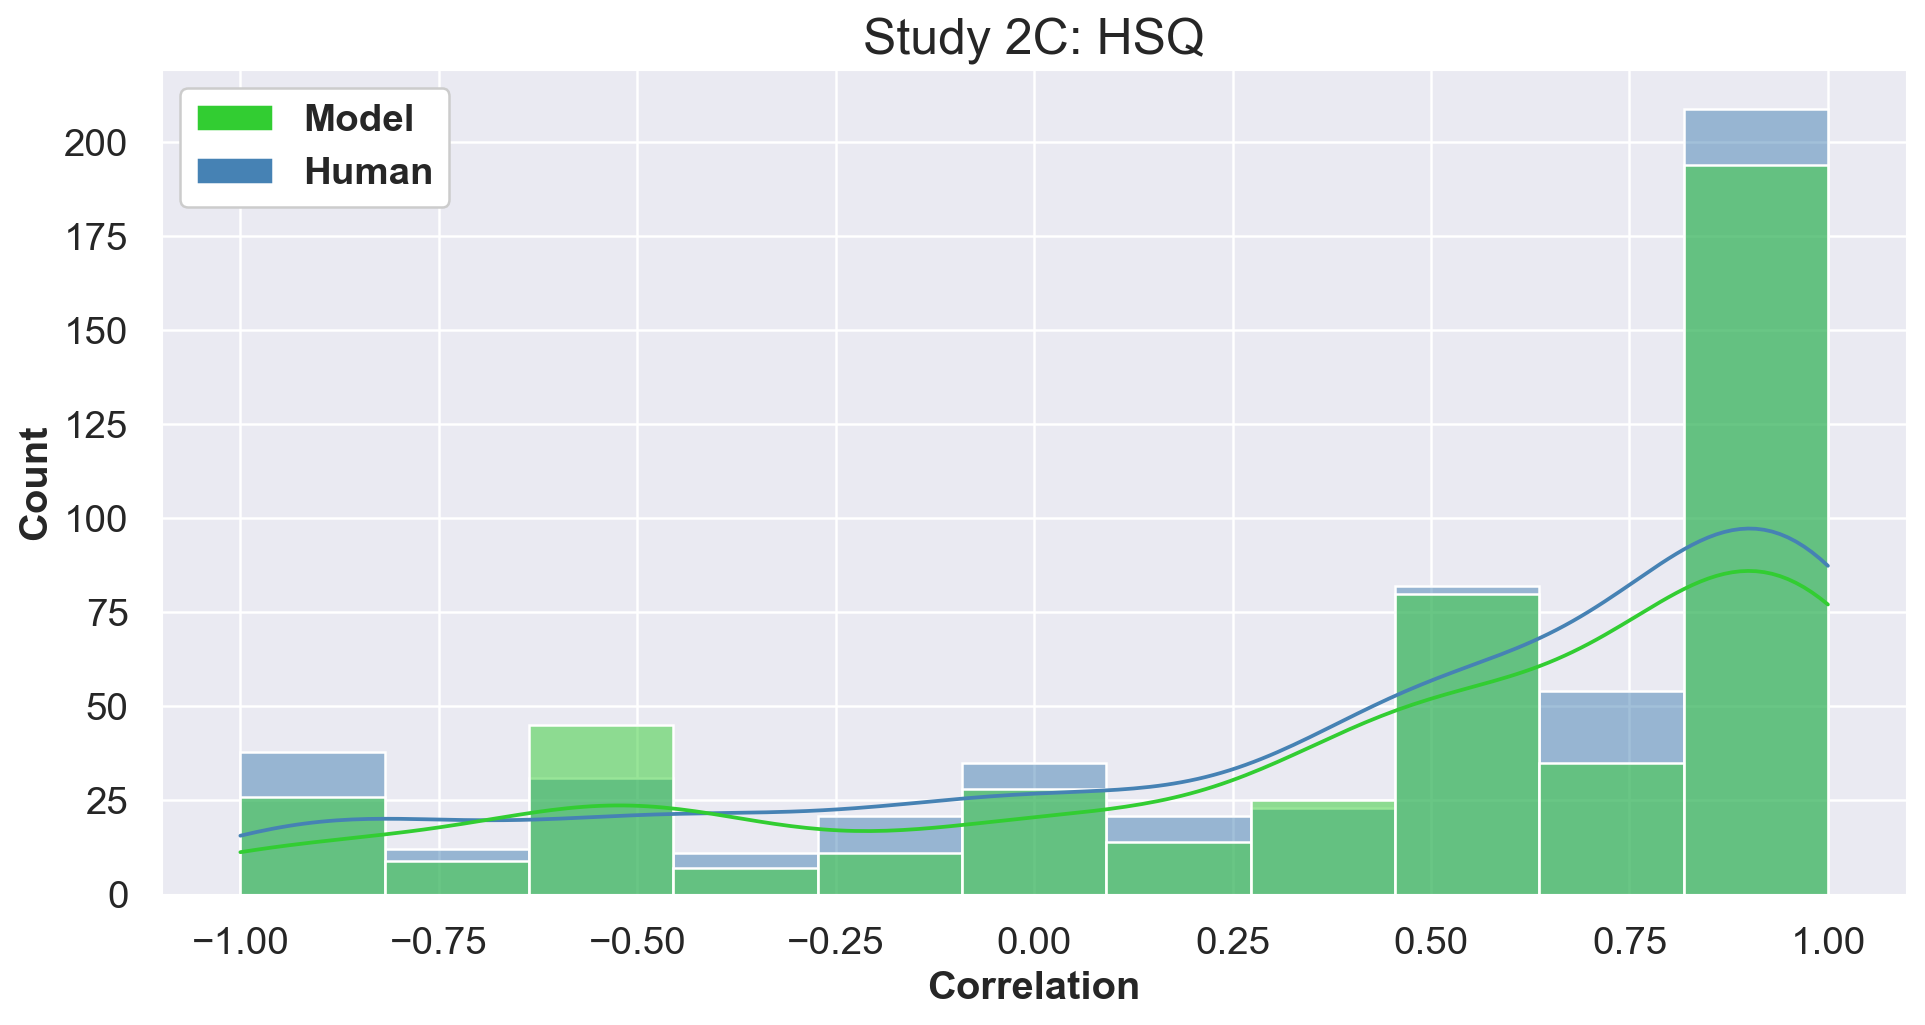

In [27]:
dataset_names = ["", 'Study 2A: 16PF', 'Study 2B: RIASEC', 'Study 2C: HSQ']

for i in range(1,len(dataset_names)): #creates figures starting after big5: numbering starts at fig_*_C
    df_comparison = df_comparisons[i-1] #get dataframe
    
    #update font size, etc
    # create barplots (comparing average performances)
    plt.style.use("seaborn-v0_8")
    sns.set_context('paper')
    sns.set(font_scale = 1.4)

    fig  = plt.figure(figsize=(11, 6), dpi= 180)
    ax = sns.barplot(y='Correlation', x='Predictor', orient='v', data=df_comparison, errorbar=('ci', 95), 
                     palette=["limegreen","steelblue"], capsize=0.07, errwidth=2)
    plt.ylabel("Correlation", fontweight='bold', fontsize=20)
    plt.xlabel("", fontweight='bold', fontsize=20, labelpad=-13)
    plt.xticks(fontsize=23)
    plt.yticks(fontsize=23)
    plt.title(dataset_names[i], fontsize=20)

    fig_name = "fig4_" + chr(65+3*i) + ".pdf"
    plt.savefig("../plot_data/" + fig_name, bbox_inches='tight')

    #Add the distribution plots for each data set:
    fig  = plt.figure(figsize=(11, 6), dpi= 180)
    palette=["limegreen","steelblue"]
    ax = sns.histplot(df_comparison, x="Correlation", kde=True, hue="Predictor", palette = palette)
    handles = [Patch(facecolor=item) for item in palette]
    labels = df_comparison.Predictor.unique().tolist()
    ax.legend(loc = "upper left", handles = handles, labels = labels, frameon = True, framealpha = 1.0, facecolor='white', prop={'weight':'bold'})
    ax.set_ylabel('Count', fontweight = "bold", fontsize = 16)
    ax.set_xlabel('Correlation', fontweight = "bold", fontsize = 16)
    plt.title(dataset_names[i], fontsize=20)

    #save figures
    fig_name = "fig4_" + chr(65+3*i+1) + ".pdf" #update figure name (to skip 3rd number)
    plt.savefig("../plot_data/" + fig_name, bbox_inches='tight')
    # files.download(fig_name)

    plt.tight_layout()
    plt.subplots_adjust(hspace = 1)
    plt.show()        

### Scatterplots

C:\Users\suhai\AppData\Local\Temp\ipykernel_4212\1409771249.py:12: RuntimeWarning: Mean of empty slice
  humans = nanmean(targets_h[i])
C:\Users\suhai\AppData\Local\Temp\ipykernel_4212\1409771249.py:13: RuntimeWarning: Mean of empty slice
  model = nanmean(targets_m[i])


(0.6992821594860222, 7.247033378583855e-10)
(0.5307219726756942, 1.288518256826051e-05)


C:\Users\suhai\AppData\Local\Temp\ipykernel_4212\1409771249.py:12: RuntimeWarning: Mean of empty slice
  humans = nanmean(targets_h[i])
C:\Users\suhai\AppData\Local\Temp\ipykernel_4212\1409771249.py:13: RuntimeWarning: Mean of empty slice
  model = nanmean(targets_m[i])


(0.4642035727447916, 0.00021275446095890468)


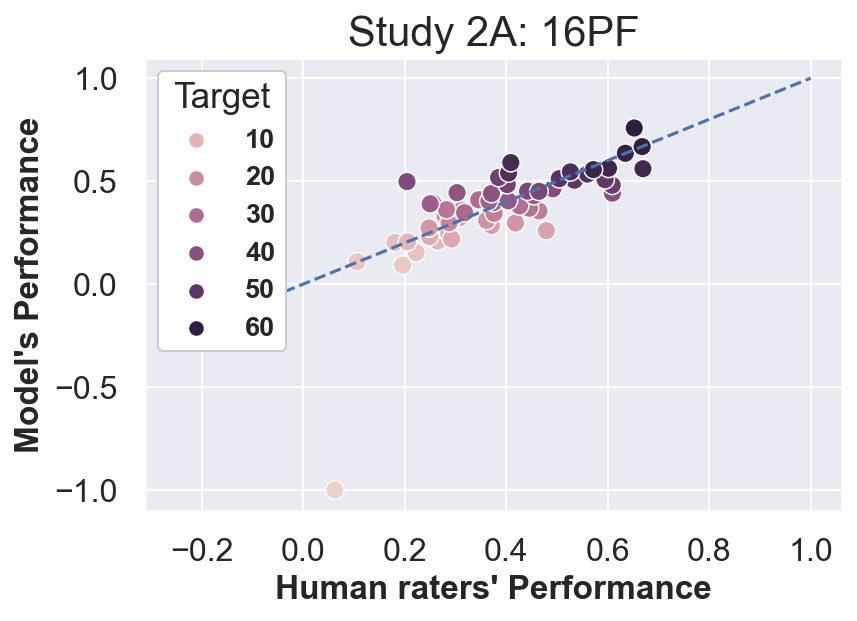

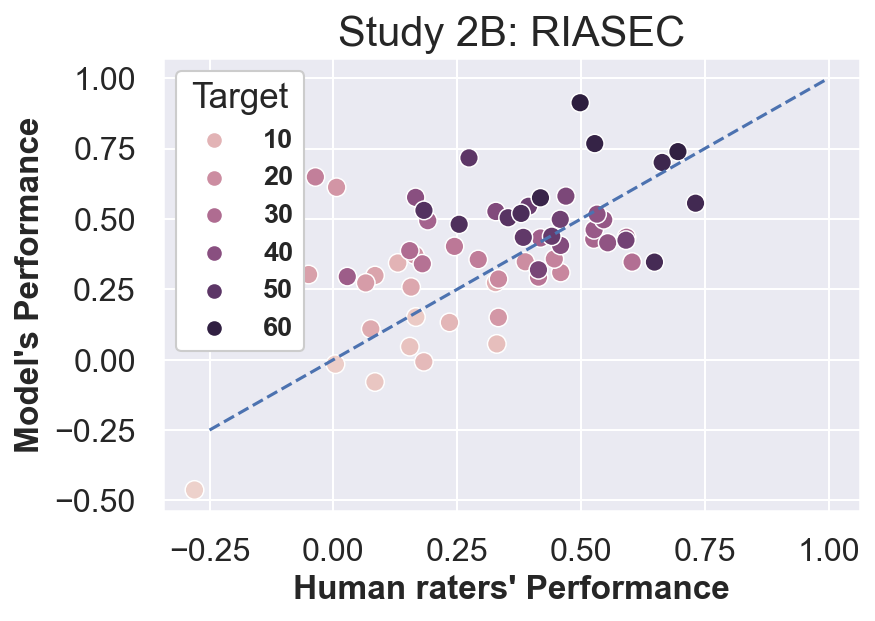

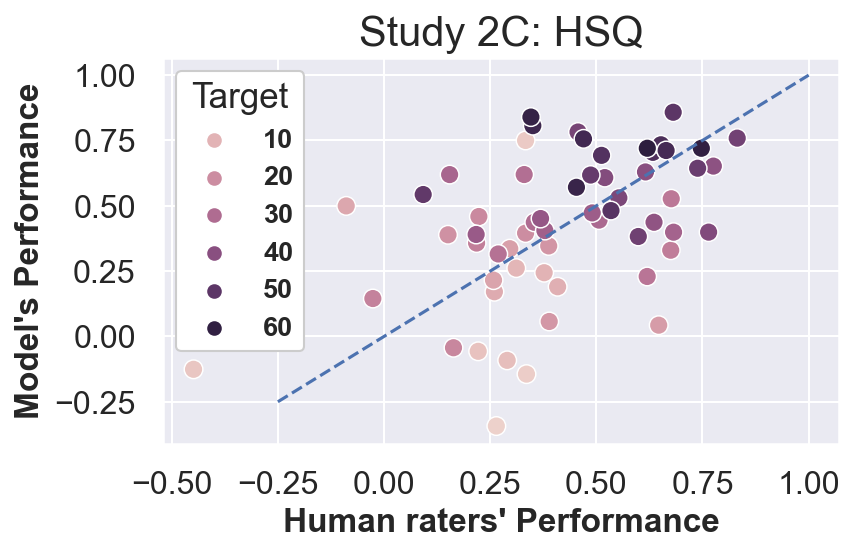

In [28]:
#update font size, etc
# create barplots (comparing average performances)
plt.style.use("seaborn-v0_8")
sns.set_context('paper')
sns.set(font_scale = 1.4)

for j, (targets_h, targets_m) in enumerate(targets_comparisons):    
    # Looks balanced -> both equally good
    rows = []
    targets=list(range(2,62))
    for i in range(60):
      humans = nanmean(targets_h[i])
      model = nanmean(targets_m[i])
      target = targets[i]
      # if model < -0.9 and humans > 0.0:
      #       continue
      rows.append([humans, model, target])
    df = pd.DataFrame(rows, columns=["humans", "model", "target"])
    # color_mapping = {'25th Percentile':'red', '50th Percentile':'white', '75th Percentile':'blue'}

    fig, ax = plt.subplots(figsize=(6, 4), dpi = 150) #figure specs
    sns.scatterplot(data=df, x="humans", y="model", hue="target", s=80, alpha=1.0)

    # # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Model\'s Performance', fontweight = "bold", fontsize=16)
    ax.set_xlabel('Human raters\' Performance', fontweight = "bold", fontsize=16)
    ax.legend(loc="upper left", frameon = True, framealpha = 1.0, facecolor='white', prop={'weight':'bold','size':13}, title="Target")
    ax.plot((-0.25, 1),(-0.25, 1), ls='--')
    plt.title(dataset_names[j+1], fontsize=20)

    fig_name = "fig4_" + chr(65+3*(j+1)+2) + ".pdf" #start at B (big5 is A)
    plt.savefig("../plot_data/" + fig_name, bbox_inches='tight')
    
    #correlation of human and model performance
    # drop NAs
    x = df.humans.dropna()
    y = df.model[x.index].dropna()
    x = x[y.index].dropna()
    
    corr = pearsonr(x, y)
    print(corr)
    
plt.tight_layout()
plt.subplots_adjust(hspace = 1)
plt.show()